In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

22

# set_seed(42)

In [2]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [3]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [4]:
import os
os.listdir()

['Product_Data_summarize(undone).ipynb',
 'Product_Data_SQuAD_wordninja.ipynb',
 'wordninja斷詞.ipynb',
 'preprocess_for_SQUAD.csv',
 'Train_Product_Data_2021_0114.csv',
 'Product_Data_SQuAD_knowledge distillation V2.ipynb',
 '全部集合.txt.gz',
 'Product_Data_ner.ipynb',
 'submit.csv',
 'Product_Data_SQuAD_model_V2.pt',
 'EDA.ipynb',
 '台塑企業_ 產品寶典20210303.xlsx',
 'aclImdb',
 'preprocess_for_SQUAD_wordninja.csv',
 'load_model_and_test-V2.ipynb',
 '產品集合.txt',
 'load_model_and_test.ipynb',
 'aclImdb_v1.tar.gz',
 'Collection method.ipynb',
 'Product_Data_SQuAD_knowledge distillation.ipynb',
 'Val_Product_Data_2021_0114.csv',
 'wordninja_words.txt',
 'Product_Data_SQuAD_model.pt',
 'combined_excel.xlsx',
 'squad_finetuning_example.ipynb',
 '全部集合.txt',
 'Product_Data_SQuAD.ipynb',
 '.ipynb_checkpoints']

In [5]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('preprocess_for_SQUAD_wordninja.csv',index_col=0)[['45A','Y_label','string_Y_1','string_Y_2']].dropna(axis=0)
df.iloc[:,-2:] = df.iloc[:,-2:].astype(int)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df = df.rename(columns={'45A':'string_X_train'})
print(df.shape)
train_df, val_df = train_test_split(df,test_size=0.3,random_state=42)
display(train_df.head(100))
display(val_df.head(100))

(3064, 4)


,string_X_train,Y_label,string_Y_1,string_Y_2
2563,COMMODITY MONO ETHYLENE GLYCOL MEG FIBER GRAD ...,MONO ETHYLENE GLYCOL MEG,10,34
1808,COMMODITY MONO ETHYLENE GLYCOL x 000 D QUANTIT...,MONO ETHYLENE GLYCOL,10,30
2276,DESCRIPTION QT Y UNIT PRICE AMOUN Tx 000 D CAR...,CARBON FIBER TC-35,43,61
538,BASE OIL 150N 1622 MT - 5 AT SELLERS OPTION x ...,BASE OIL 500N,52,65
1871,PP 2080 555 MT AT USD 1600 M Tx 000 DPP 2080 1...,PP,0,2
...,...,...,...,...
2506,1 COMMODITY ETHYLENE-PROPYLENE COPOLYMER Sx 00...,ETHYLENE-PROPYLENE COPOLYMER,12,40
2590,1 - QT Y 172000 KGS OF VISCOSE STAPLE FIBER 12...,VISCOSE STAPLE FIBER,23,43
2296,COMMODITY POLYPROPYLENE RESIN x 000 D GRADE B ...,POLYPROPYLENE,10,23
1226,TRADE TERM FOB ANY PORT IN TAIWAN x 000 D COMM...,EVA,59,62


,string_X_train,Y_label,string_Y_1,string_Y_2
1241,TERMS OF PRICE CFR ZHANG JIA GANG CHIN Ax 000 ...,MONO ETHYLENE GLYCOL,91,111
203,COMMODITY BASE OIL 150N x 000 D QUANTITY 1800 ...,BASE OIL 500N,75,88
1260,COMMODITY NAN YA TETRAHYDROFURAN 998 PERCENT M...,NAN YA TETRAHYDROFURAN,10,32
1626,1 CONTRACT NO 21 LJ S 014 x 000 D CARBON FIBER...,CARBON FIBER,34,46
1578,1 TERMS CI F SURAB AYA PORT INDONESIA IN COTE ...,EPOXY RESIN,174,185
...,...,...,...,...
637,AS PER PO NO 2413907463 DATED 20052021 GOODS D...,EA,140,142
178,TRADE TERMS CI F HE YUAN CHINA AN DOR CI F PIN...,PVC RESIN S-60,169,183
52,COMMODITY MONO ETHYLENE GLYCOL MEG QUANTITY 20...,MONO ETHYLENE GLYCOL MEG,10,34
842,COUNTRY OF ORIGIN TAIWAN x 000 D PRICE TERMS C...,VISCOSE STAPLE FIBER,69,89


# find_fail_sample and drop fail_sample

In [6]:
def find_fail_sample(df):
    fails = []
    for i in df.index:
        context = df.loc[i,'string_X_train']
        answer = df.loc[i,'Y_label']
        if answer not in context:
            fails.append(i)
    return fails
train_fails = find_fail_sample(train_df)
val_fails = find_fail_sample(val_df)
print(train_fails,val_fails)
display(val_df.loc[val_fails])
print(train_df.shape)
train_df = train_df.drop(train_fails,axis=0)
print(train_df.shape)
print(val_df.shape)
val_df = val_df.drop(val_fails,axis=0)
print(val_df.shape)

[] []


,string_X_train,Y_label,string_Y_1,string_Y_2


(2144, 4)
(2144, 4)
(920, 4)
(920, 4)


# Model and Tokenizer Initialization

In [7]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

264

# Data preprocessing

In [8]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [9]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [10]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

20

# data is ready put it in a PyTorch dataset

In [11]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

20

# train loop

In [12]:
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True ,num_workers=4)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [13]:
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch:0 train_loss:1.6307866103721387 val_loss:0.5378027792487826
save best_model now_val_best_loss is:0.5378027792487826


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch:1 train_loss:0.40338046126293414 val_loss:0.39396137424877714
save best_model now_val_best_loss is:0.39396137424877714


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch:2 train_loss:0.25583438270471315 val_loss:0.3817342296242714
save best_model now_val_best_loss is:0.3817342296242714


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch:3 train_loss:0.17284004418461613 val_loss:0.33399339073470663
save best_model now_val_best_loss is:0.33399339073470663


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

epoch:4 train_loss:0.14634721110941787 val_loss:0.3361072103892054
not_improve_count:1


# loss curve

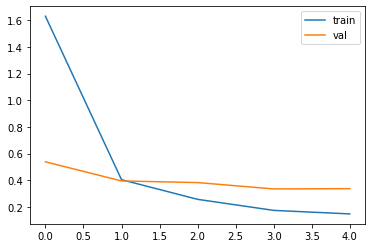

In [14]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [15]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

# test

In [16]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [17]:
all_res = test_model(val_df)
all_res

  0%|          | 0/920 [00:00<?, ?it/s]

,label,predict:,是否全對
1241,MONO ETHYLENE GLYCOL,MONO ETHYLENE GLYCOL,Yes
203,BASE OIL 500N,BASE OIL 500N,Yes
1260,NAN YA TETRAHYDROFURAN,TETRAHYDROFURAN,No
1626,CARBON FIBER,CARBON FIBER,Yes
1578,EPOXY RESIN,EPOXY RESIN,Yes
...,...,...,...
811,PURIFIED TEREPHTHALIC ACID PTA,PURIFIED TEREPHTHALIC ACID PTA,Yes
2240,TAIRIREX POLYSTYRENE,TAIRIREX POLYSTYRENE,Yes
561,BASE OIL,BASE OIL,Yes
2092,COPOLYMER PROPYLENE,COPOLYMER PROPYLENE,Yes


In [19]:
all_res[all_res['是否全對']=='No']

,label,predict:,是否全對
1260,NAN YA TETRAHYDROFURAN,TETRAHYDROFURAN,No
2925,PACK,PACKING,No
2762,ABS RESIN,ABS RESINS,No
2854,PC RESIN,DPC RESIN,No
764,HIPS RESIN,ABS RESIN,No
...,...,...,...
1364,GLASS EPOXY PREPREG,COPPER CLAD LAMINATE,No
2995,MA,PROFORMA,No
965,POLYPROPYLENE COPOLYMER RESIN,POLYPROPYLENE,No
208,PACK,PACKAGING,No


# claculate acc and jaccard

In [20]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

display(all_res['是否全對'].value_counts())
acc = all_res['是否全對'].value_counts()['Yes']/len(val_df)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

Yes    678
No     242
Name: 是否全對, dtype: int64

acc: 0.7369565217391304
jaccard_avg_score: 0.8101708074534162
